In [1]:
%load_ext zipline

In [2]:
from cryptohist import CoinMarketCapFetcher
from collections import OrderedDict
import pandas as pd
import datetime as dt
import pytz

fetcher = CoinMarketCapFetcher(start=dt.datetime(2013, 4, 28), end=dt.datetime.today())

symbols = set(fetcher.get_symbols()[:20])
data = OrderedDict()
market_caps = OrderedDict()
volumes = OrderedDict()
for symbol in symbols:
    data[symbol] = pd.read_csv("data/" + symbol + ".csv")
    
    data[symbol]['date'] = pd.to_datetime(data[symbol]['Date'])
    data[symbol].set_index('date', inplace=True)
    data[symbol].drop('Date', axis=1, inplace=True)
    data[symbol].fillna(method="ffill", inplace=True)
    market_caps[symbol] = data[symbol][["Market Cap"]].copy().fillna(0)
    volumes[symbol] = data[symbol][["Volume"]].copy().fillna(0)
    data[symbol] = data[symbol][["Low","High","Open","Close","Volume"]]

panel = pd.Panel(data)
panel.minor_axis = ["low","high","open","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

prices_df = pd.DataFrame()
for symbol in data.keys():
    prices_df[symbol] = data[symbol]["Open"]

<class 'pandas.core.panel.Panel'>
Dimensions: 20 (items) x 1831 (major_axis) x 5 (minor_axis)
Items axis: BCH to DASH
Major_axis axis: 2013-04-28 00:00:00+00:00 to 2018-05-02 00:00:00+00:00
Minor_axis axis: low to volume


In [72]:
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import coint

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs
    return score_matrix, pvalue_matrix, pairs

def calc_zscore(series):
    return (series - series.mean()) / np.std(series)

/Users/alec/.pyenv/versions/3.5.0/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1018: UserWarning: y0 and y1 are perfectly colinear.  Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are perfectly colinear.  Cointegration test "


[('BCH', 'BTC'), ('BCN', 'ADA'), ('BCN', 'QTUM'), ('LSK', 'NEO'), ('LSK', 'ETH'), ('XEM', 'QTUM'), ('LTC', 'XMR')]


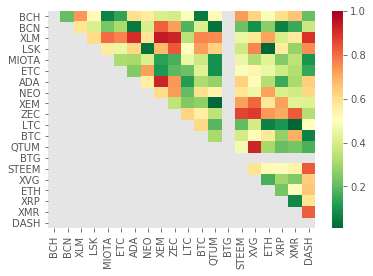

In [73]:
start, end = "2017-10-01", "2018-05-02"
prices = prices_df[start:end]
scores, pvalues, pairs = find_cointegrated_pairs(prices)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbols, yticklabels=symbols, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.95)
                )
print(pairs)

0.04409076423251347


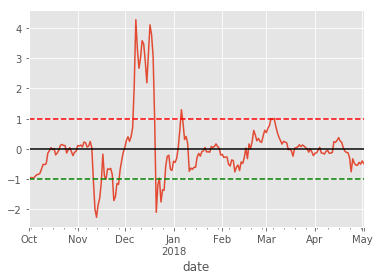

In [75]:
import matplotlib.pyplot as plt
from matplotlib import style
import statsmodels.api as sm


style.use("ggplot")

s1, s2 = ('BCH', 'BTC')
S1 = prices[s1]
S2 = prices[s2]
score, pvalue, _ = coint(S1, S2)
print(pvalue)
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[s1]
b = results.params[s1]

spread = S2 - b * S1
zscore(spread).plot()

plt.axhline(calc_zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.show()

In [138]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from zipline.utils import tradingcalendar
import pytz
from zipline.api import order, order_target, record, symbol, set_benchmark, set_commission, set_slippage, order_target_percent, get_open_orders, get_datetime, order_percent
from zipline.finance import commission, slippage


def initialize(context):
    # Quantopian backtester specific variables
    set_slippage(slippage.FixedSlippage(spread=0))
    set_commission(commission.PerTrade(cost=0))
    context.Y = symbol('ETH')
    context.X = symbol('LSK')
    
    
    # strategy specific variables
    context.lookback = 180 # used for regression
    context.z_window = 30 # used for zscore calculation, must be <= lookback
    context.wait = 365
    context.i = 0
    context.useHRlag = False
    context.HRlag = 2
    
    context.spread = np.array([])
    context.hedgeRatioTS = np.array([])
    context.inLong = False
    context.inShort = False
    context.entryZ = 1
    context.exitZ = 0.1

    if not context.useHRlag:
        # a lag of 1 means no-lag, this is used for np.array[-1] indexing
        context.HRlag = 1
        
# Will be called on every trade event for the securities you specify. 
def handle_data(context, data):
    record(BTC=data.current(symbol('BTC'), fields='price'))
    record(X=data.current(context.X, fields='price'))
    record(Y=data.current(context.Y, fields='price'))
    
    context.i += 1
    _Y_value = context.portfolio.positions[context.Y].amount * context.portfolio.positions[context.Y].last_sale_price
    _X_value = context.portfolio.positions[context.X].amount * context.portfolio.positions[context.X].last_sale_price
    _leverage = (abs(_Y_value) + abs(_X_value)) / context.portfolio.portfolio_value
    record(
            X_value = _X_value ,
            Y_value = _Y_value ,
            leverage = _leverage
    )
    
    if get_open_orders():
        return
    
    now = get_datetime()
    
    Y = data.history(context.Y, 'price', bar_count=context.lookback, frequency="1d")
    X = data.history(context.X, 'price', bar_count=context.lookback, frequency="1d")

    try:
        hedge = hedge_ratio(Y, X, add_const=False)      
    except ValueError as e:
        log.debug(e)
        return
    
    context.hedgeRatioTS = np.append(context.hedgeRatioTS, hedge)
    # Calculate the current day's spread and add it to the running tally
    if context.hedgeRatioTS.size < context.HRlag:
        return
    # Grab the previous day's hedgeRatio
    hedge = context.hedgeRatioTS[-context.HRlag]  
    context.spread = np.append(context.spread, Y[-1] - hedge * X[-1])

    if context.spread.size > context.z_window and context.i > context.wait:
        # Keep only the z-score lookback period
        spreads = context.spread[-context.z_window:]
        
        zscore = calc_zscore(spreads)[-1]
          
        if context.inShort and zscore < context.exitZ:
            order_target(context.Y, 0)
            order_target(context.X, 0)
            context.inShort = False
            context.inLong = False
            record(X_pct=0, Y_pct=0)
            return
        
        if context.inLong and zscore > context.exitZ:
            order_target(context.Y, 0)
            order_target(context.X, 0)
            context.inShort = False
            context.inLong = False
            record(X_pct=0, Y_pct=0)
            return
            
        if zscore < -context.entryZ and (not context.inLong):
            # Only trade if NOT already in a trade
            y_target_shares = 1
            X_target_shares = -hedge
            context.inLong = True
            context.inShort = False
            
            (y_target_pct, x_target_pct) = computeHoldingsPct( y_target_shares,X_target_shares, Y[-1], X[-1] )
            order_target_percent(context.Y, y_target_pct)
            order_target_percent(context.X, x_target_pct)
            record(Y_pct=y_target_pct, X_pct=x_target_pct)
            return

        if zscore > context.entryZ and (not context.inShort):
            # Only trade if NOT already in a trade
            y_target_shares = -1
            X_target_shares = hedge
            context.inShort = True
            context.inLong = False
           
            (y_target_pct, x_target_pct) = computeHoldingsPct( y_target_shares, X_target_shares, Y[-1], X[-1] )
            order_target_percent(context.Y, y_target_pct)
            order_target_percent(context.X, x_target_pct)
            record(Y_pct=y_target_pct, X_pct=x_target_pct)

def hedge_ratio(Y, X, add_const=True):
    if add_const:
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        return model.params[1]
    model = sm.OLS(Y, X).fit()
    return model.params.values
    
def computeHoldingsPct(yShares, xShares, yPrice, xPrice):
    yDol = yShares * yPrice
    xDol = xShares * xPrice
    notionalDol =  (abs(yDol) + abs(xDol))
    y_target_pct = yDol / notionalDol
    x_target_pct = xDol / notionalDol
    return (y_target_pct, x_target_pct)

In [139]:
import zipline
from zipline.utils.calendars.exchange_calendar_24hr import TwentyFourHR
perf = zipline.run_algorithm(start=dt.datetime(2016, 10, 1, 0, 0, 0, 0, pytz.utc),
                      end=dt.datetime(2018, 5, 1, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      trading_calendar=TwentyFourHR(),
                      capital_base=1000000,
                      handle_data=handle_data,
                      data_frequency ='daily',
                      data=panel)

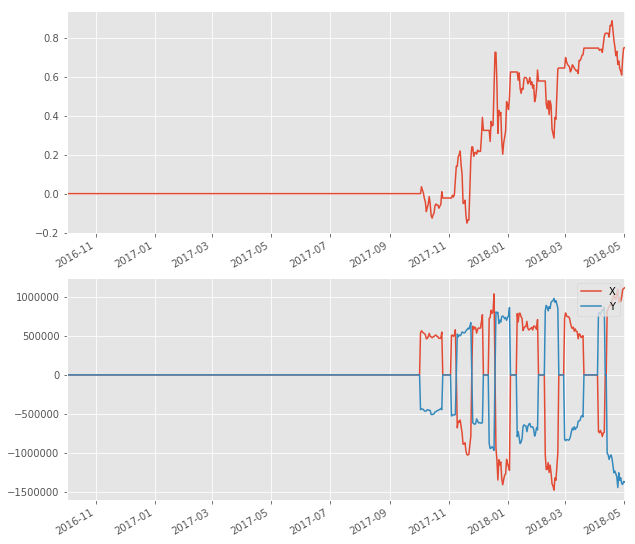

In [140]:
style.use("ggplot")

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio', ax=ax1)


ax2 = fig.add_subplot(212)
perf.X_value.plot(label='X', ax=ax2)
perf.Y_value.plot(label='Y', ax=ax2)

plt.legend(loc=1)  
plt.show()